In [1]:
#######imports and data read#######
import copy
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from pre_processing import *
from algorithms import *
from spectrum_gen import *
from data_gen import *
from analysis import *
from datasets import *
from evaluation import *
#cr_filtering()
#cr_read_norm()1dasdas
import h5py
import scanpy as sc
from sklearn.metrics import adjusted_rand_score
gene_list_for_plot = ['CDC20','CDK1','RRM2','PCNA']
#adata = sc.read_csv('hela/GSM4224316_out_gene_exon_tagged.dge_exonssf002_KO.txt', delimiter='\t').T
adata = sc.read_csv('hela/GSM4224315_out_gene_exon_tagged.dge_exonssf002_WT.txt', delimiter='\t').T
adata = shuffle_adata(adata)
adata


View of AnnData object with n_obs × n_vars = 1029 × 25797

In [2]:
#######data cleaning#######
#sc.pp.filter_genes(adata, min_cells=10)
sc.pp.filter_cells(adata, min_genes=0)
i=1
while adata.obs['n_genes'].mean() <4500: #remove cells until we reach mean counts of 4,500 as suggested by https://www.embopress.org/doi/full/10.15252/msb.20209946
    sc.pp.filter_cells(adata, min_genes=i)
    i+=5
#sc.pp.filter_cells(adata, min_counts=3000) #4000
adata_for_inference = adata.copy()
adata

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 683 × 25797
    obs: 'n_genes'

/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


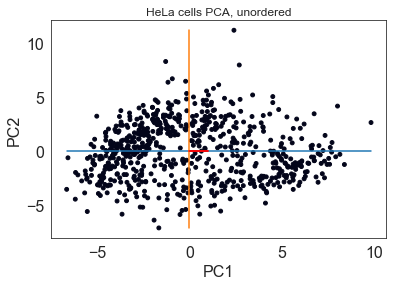

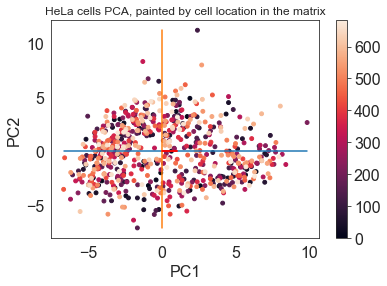

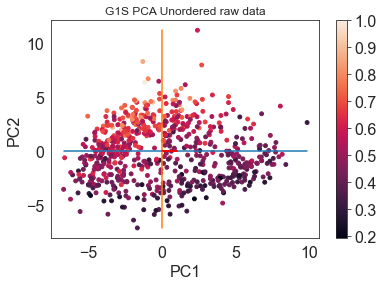

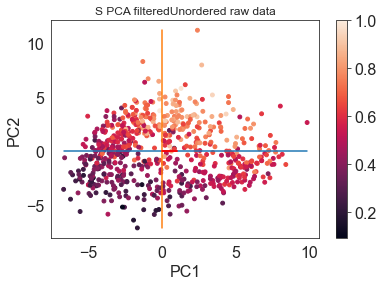

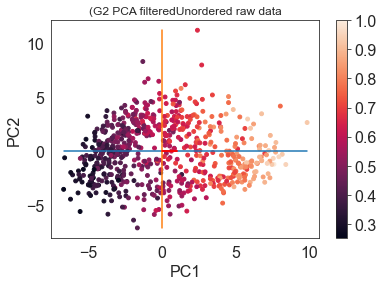

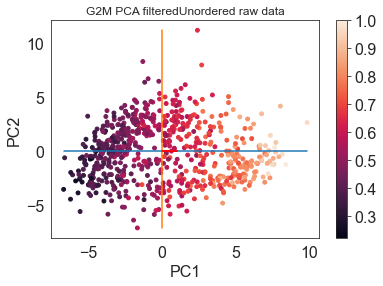

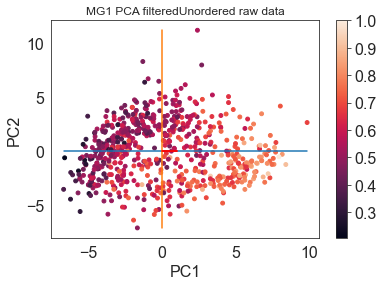

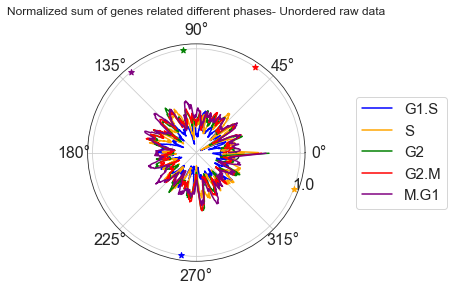

Circular mean and variance, G1S(-1.7207748303139037, 0.9907960726508558)
Circular mean and variance, S(-0.3571861715983738, 0.9880356874623137)
Circular mean and variance, G2(1.6993680743497552, 0.9980920299495504)
Circular mean and variance, G2M(0.9643724378147743, 0.9932004448430688)
Circular mean and variance, MG1(2.2483666671913873, 0.9940602093008902)


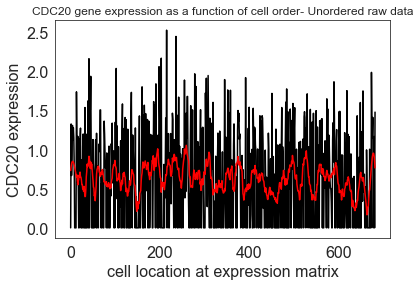

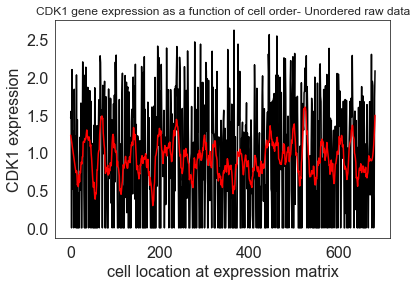

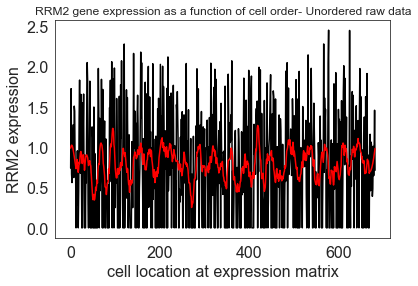

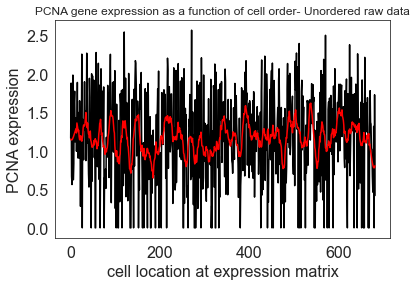

Mean AUC-ROC: 0.3122750000000001


In [3]:
#######data cleaning#######
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
bdata = copy.deepcopy(adata.copy())
sc.pp.filter_genes_dispersion(adata,n_top_genes=7000)
ranged_pca_2d(adata.X,color=np.zeros(adata.X.shape[0]),title=("HeLa cells PCA, unordered"),dis_colorbar=True)
all_plots_hela(adata,title="Unordered raw data")
plot_gene_list(adata, gene_list_for_plot, color1='black', color2='r', title="Unordered raw data")
#######Gene inference over un-ordered data- the result expected to be low#######
auc_unordered= np.zeros(100)
for i in range(100):
    auc_unordered[i] = hela_gene_inference(adata, number_of_genes=100)
print("Mean AUC-ROC: " + str(np.mean(auc_unordered)))

Iteration number: 0 function value= 1.1981150543746724e-22
Iteration number: 25 function value= 558.6395587983488
Iteration number: 50 function value= 559.0641315701971
Iteration number: 75 function value= 566.0940190434208
Iteration number: 100 function value= 578.424971778993
Iteration number: 125 function value= 575.7976114393239
Iteration number: 150 function value= 582.9394393471296
Iteration number: 175 function value= 577.9563634517156
Iteration number: 200 function value= 584.9825576404178
Iteration number: 225 function value= 584.6956261869018


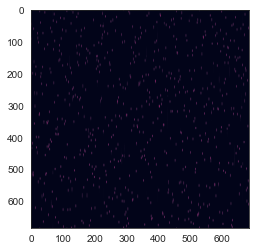

In [4]:
E_sga  , E_rec_sga = reconstruction_cyclic(adata.X , iterNum=250 , batch_size=6000)
plt.imshow(E_sga)
plt.show()

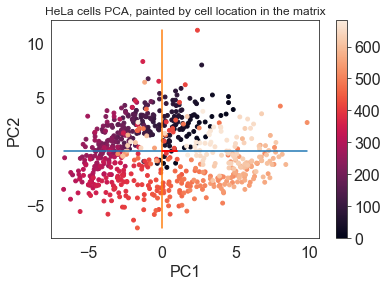

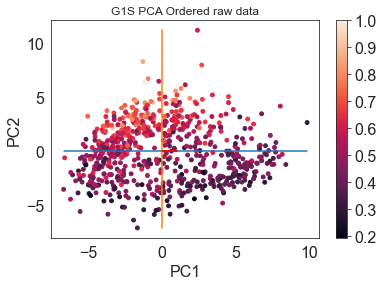

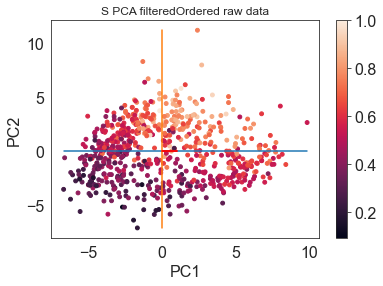

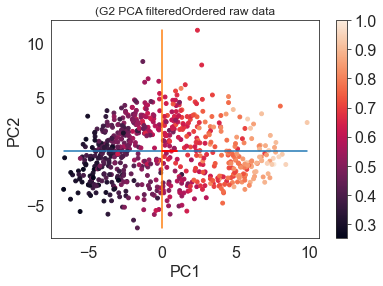

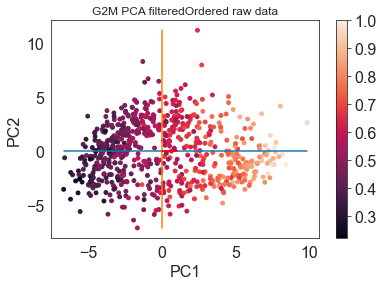

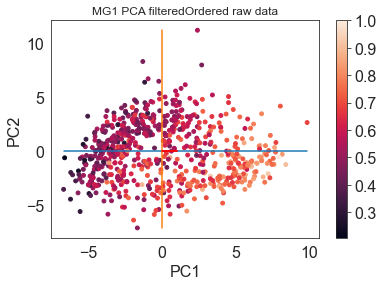

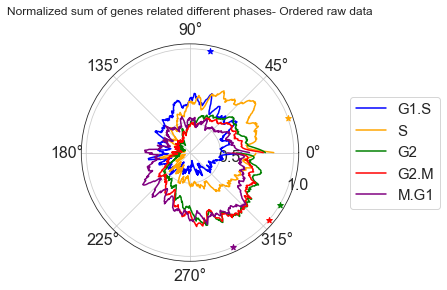

Circular mean and variance, G1S(1.3818886803665142, 0.8914672563997802)
Circular mean and variance, S(0.34294978926513736, 0.829864063349843)
Circular mean and variance, G2(-0.5267620141611244, 0.8123091743981095)
Circular mean and variance, G2M(-0.7121822337128254, 0.8287128050812745)
Circular mean and variance, MG1(-1.145751342970279, 0.8897422294094702)


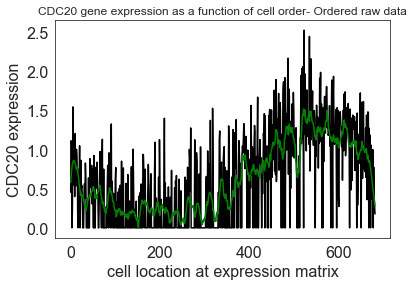

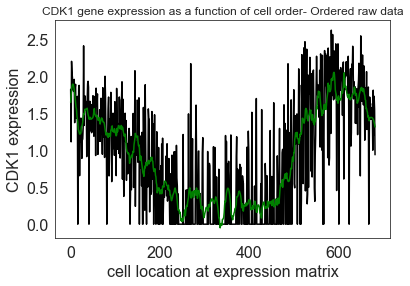

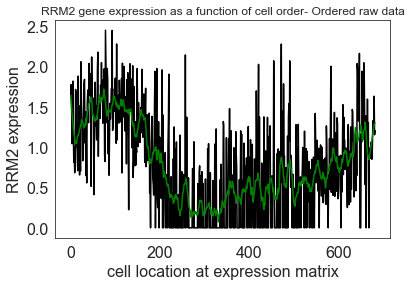

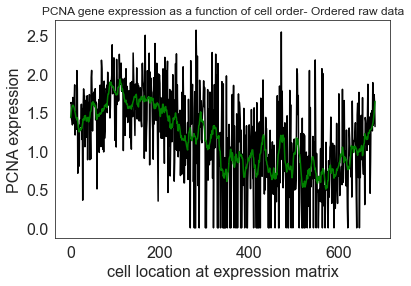

Mean AUC-ROC: 0.7993745


In [5]:
#######Signal reconstruction######
sga_range= e_to_range(E_rec_sga)
adata = adata[sga_range,:]
orig_adata = copy.deepcopy(adata.copy())
all_plots_hela(adata,title="Ordered raw data")
plot_gene_list(adata, gene_list_for_plot, color1='black', color2='g', title="Ordered raw data")
auc_ordered= np.zeros(100)
#######Gene inference over ordered data#######
for i in range(100):
    auc_ordered[i] = hela_gene_inference(adata, number_of_genes=100)
print("Mean AUC-ROC: " + str(np.mean(auc_ordered)))

Iteration number: 1 function value: 501.8021504620105
Iteration number: 26 function value: 1090.4203523908243
Iteration number: 51 function value: 2571.5302083242354
Iteration number: 76 function value: 3369.105040473772
norm change 447.7489388680998


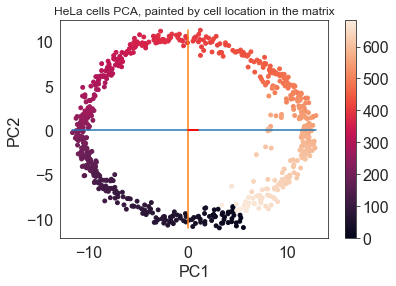

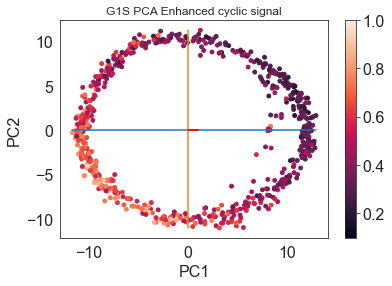

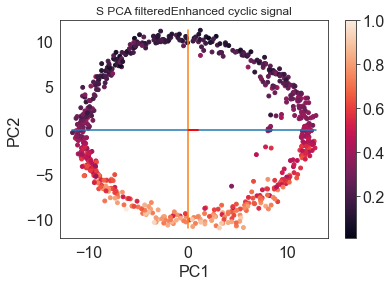

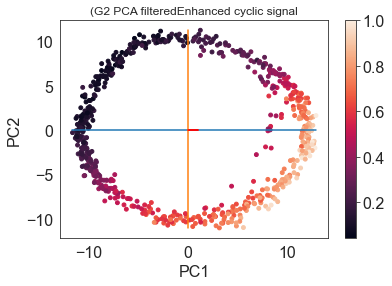

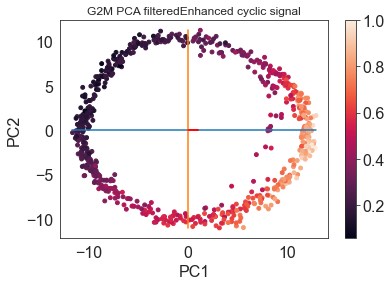

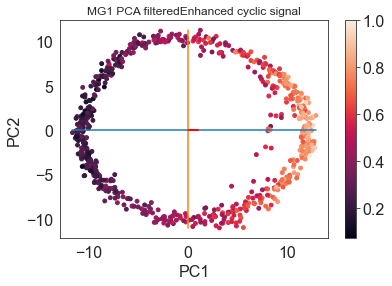

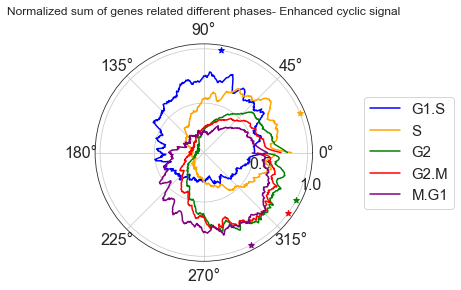

Circular mean and variance, G1S(1.4017984592916042, 0.7898602991722198)
Circular mean and variance, S(0.39314323530867645, 0.6485812875154998)
Circular mean and variance, G2(-0.47044636310353, 0.5659641844266146)
Circular mean and variance, G2M(-0.6270776724246453, 0.6421566859145379)
Circular mean and variance, MG1(-1.0974692973625682, 0.6940572374639866)


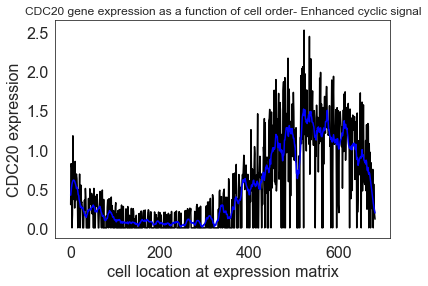

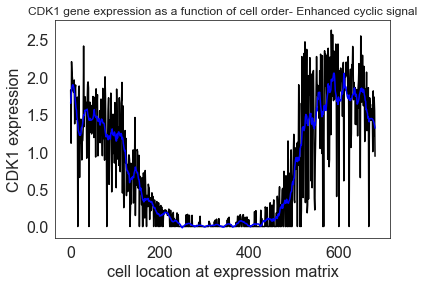

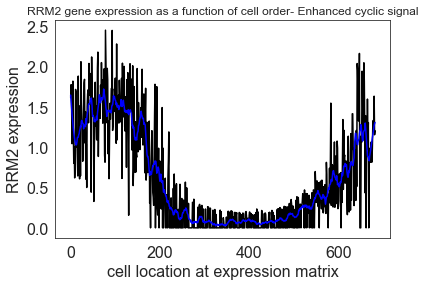

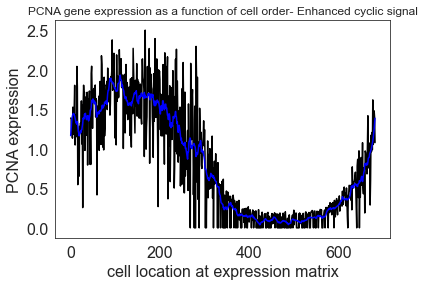

Mean AUC-ROC: 0.8313035


In [6]:
#######Signal enhancement######
adata = orig_adata.copy()
F = enhancement_cyclic(adata.X,regu=0.05,iterNum=100)
print("norm change " +str(np.linalg.norm(orig_adata.X - adata.X * F)))
adata.X = adata.X * F
all_plots_hela(adata,title="Enhanced cyclic signal")
plot_gene_list(adata, gene_list_for_plot, color1='black', color2='b', title="Enhanced cyclic signal")
auc_en= np.zeros(100)
for i in range(100):
    auc_en[i] = hela_gene_inference(adata, number_of_genes=100)
print("Mean AUC-ROC: " + str(np.mean(auc_en)))

starting filtering
25th Iteration    Loss :: 105.25392999626843 gradient :: 2.4726858432971124
50th Iteration    Loss :: 50.97213494232805 gradient :: 1.2599297896171915
75th Iteration    Loss :: 33.891395524390475 gradient :: 0.839655880153725
100th Iteration    Loss :: 25.767732632671517 gradient :: 0.6268619180895972
125th Iteration    Loss :: 21.0633002906996 gradient :: 0.49939978964252424
150th Iteration    Loss :: 18.003671010962783 gradient :: 0.41524305899280217
175th Iteration    Loss :: 15.848114743489326 gradient :: 0.35581889440899567
200th Iteration    Loss :: 14.24159192609596 gradient :: 0.3117729852787795
225th Iteration    Loss :: 12.993071296342144 gradient :: 0.27789210584573604
250th Iteration    Loss :: 11.991112110681346 gradient :: 0.25107624457704125
275th Iteration    Loss :: 11.16675611999525 gradient :: 0.22935912508133235
300th Iteration    Loss :: 10.474261988923597 gradient :: 0.211409095933608
325th Iteration    Loss :: 9.882489297710986 gradient :: 0.19

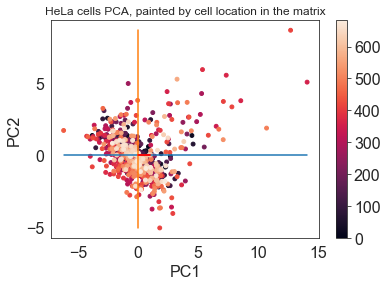

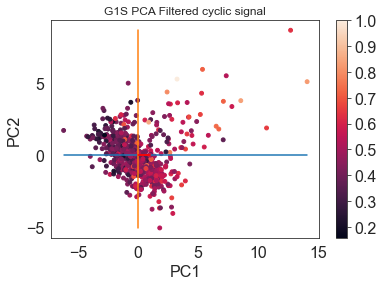

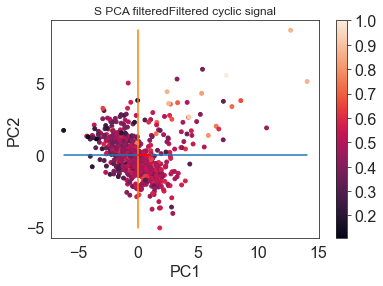

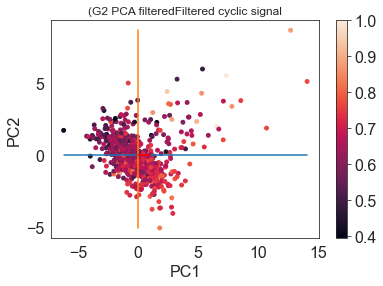

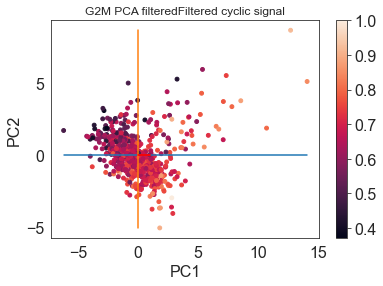

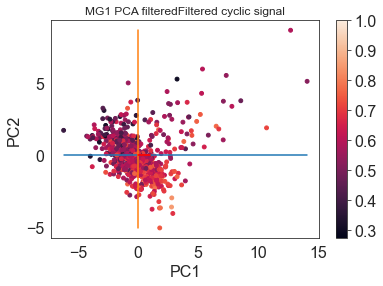

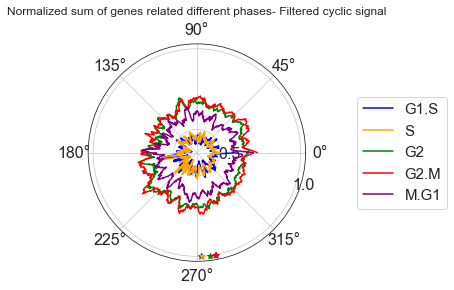

Circular mean and variance, G1S(-1.5269251019408783, 0.9896085841136674)
Circular mean and variance, S(-1.5190109058938308, 0.9891968969514288)
Circular mean and variance, G2(-1.4474824230122199, 0.9890689623871101)
Circular mean and variance, G2M(-1.3952885122482905, 0.9888449198831767)
Circular mean and variance, MG1(-1.3885412297618047, 0.9888261928039656)


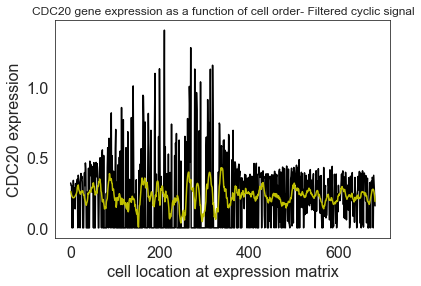

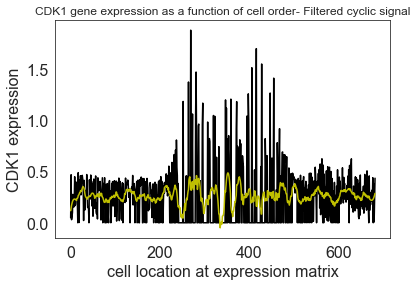

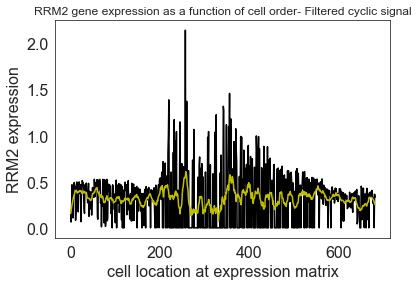

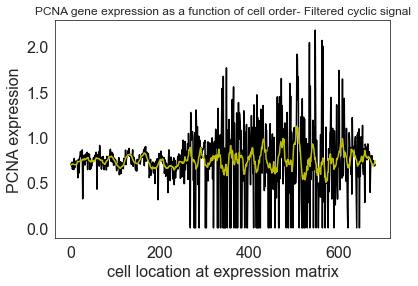

Mean AUC-ROC: 0.19037649999999995


In [7]:
#######Signal filtering######
adata = copy.deepcopy(orig_adata.copy())
F = filtering_cyclic(adata.X,regu=0,iterNum=1500)
print("norm change " +str(np.linalg.norm(orig_adata.X - adata.X * F)))
adata.X = adata.X * F
all_plots_hela(adata,title="Filtered cyclic signal")
plot_gene_list(adata, gene_list_for_plot, color1='black', color2='y', title="Filtered cyclic signal")
auc_filtered= np.zeros(100)
for i in range(100):
    auc_filtered[i] = hela_gene_inference(adata, number_of_genes=100)
print("Mean AUC-ROC: " + str(np.mean(auc_filtered)))

starting norm: 885.044
Iteration number: 1 function value: 501.7973112540076
norm change 48.215010248561924


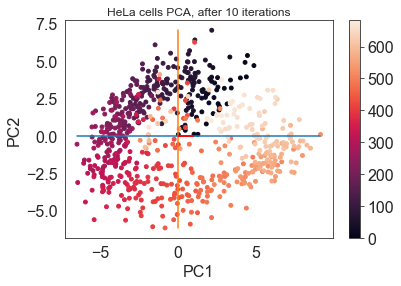

Iteration number: 1 function value: 501.79511294547365
norm change 108.70100922491912


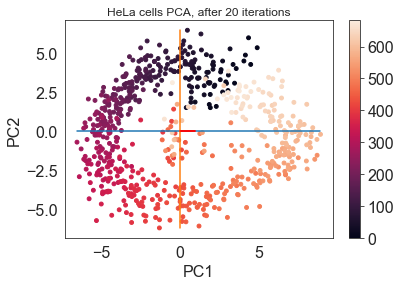

Iteration number: 1 function value: 501.8070912927224
Iteration number: 26 function value: 1090.319077024096
norm change 191.85582726628937


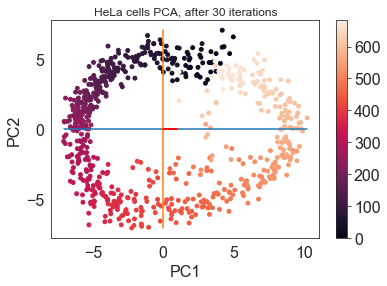

Iteration number: 1 function value: 501.82020339278614
Iteration number: 26 function value: 1090.1511456208461
norm change 261.00438890137923


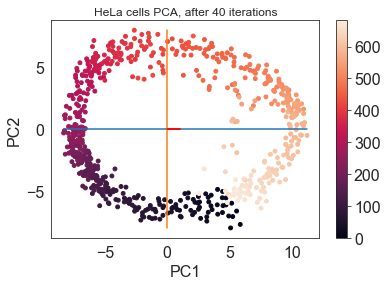

Iteration number: 1 function value: 501.8030895466307
Iteration number: 26 function value: 1090.4497951992598
norm change 311.3586760776905


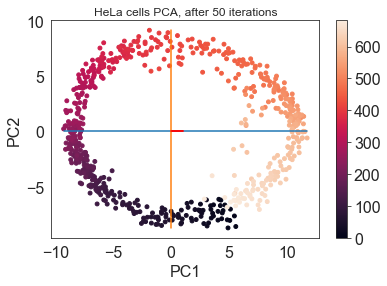

Iteration number: 1 function value: 501.80903943043313
Iteration number: 26 function value: 1090.4313720843554
Iteration number: 51 function value: 2570.594202789391
norm change 347.3774045205805


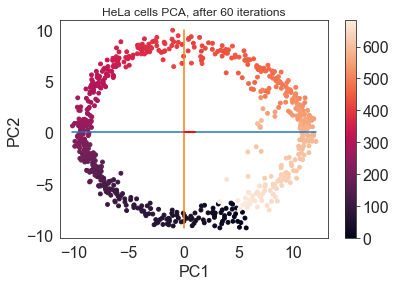

Iteration number: 1 function value: 501.8008819103458
Iteration number: 26 function value: 1090.0785457936379
Iteration number: 51 function value: 2571.1536423462694
norm change 377.37749714052245


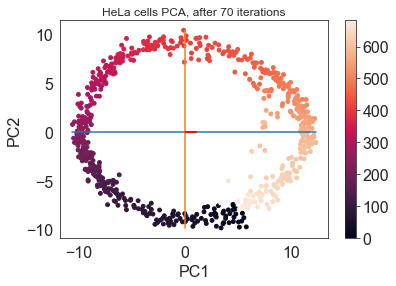

Iteration number: 1 function value: 501.7997903465915
Iteration number: 26 function value: 1089.958287640353
Iteration number: 51 function value: 2571.3861745257063
Iteration number: 76 function value: 3368.8269350283813
norm change 404.1931745615888


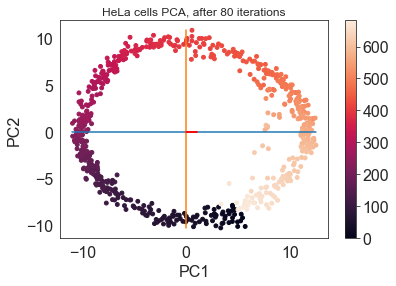

Iteration number: 1 function value: 501.80647994047126
Iteration number: 26 function value: 1089.8571327822403
Iteration number: 51 function value: 2570.8038300493276
Iteration number: 76 function value: 3368.6376066027724
norm change 427.45517671007


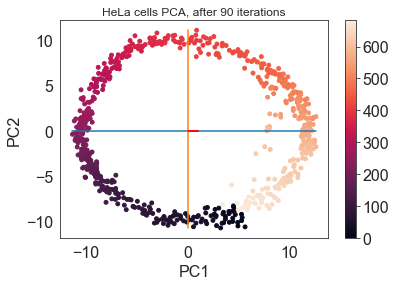

Iteration number: 1 function value: 501.80980210513684
Iteration number: 26 function value: 1089.9953600064023
Iteration number: 51 function value: 2571.3639293461647
Iteration number: 76 function value: 3368.7283972628193
norm change 447.7362949801531


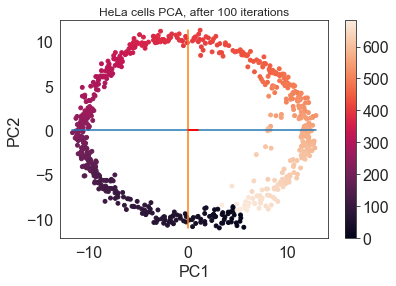

In [8]:
print("starting norm: " +str(np.linalg.norm(orig_adata.X)))
adata = copy.deepcopy(orig_adata.copy())
for i in range(10):
    adata = copy.deepcopy(orig_adata.copy())
    F = enhancement_cyclic(adata.X,regu=0.05,iterNum=(10*(i+1)))
    print("norm change " +str(np.linalg.norm(orig_adata.X - adata.X * F)))
    adata.X = adata.X * F
    ranged_pca_2d(adata.X,color=range(adata.X.shape[0]),title=("HeLa cells PCA, after "+ str((i+1)*10) +" iterations"))

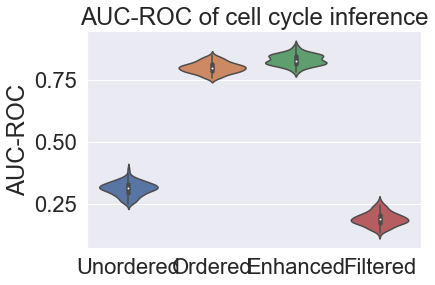

In [9]:
data = pd.DataFrame({
    "Unordered": auc_unordered,
    'Ordered': auc_ordered,
    "Enhanced": auc_en,
    "Filtered": auc_filtered,
})
sns.set_style("whitegrid")

sns.set_style("white", {"axes.facecolor": ".9"})
sns.set_style("whitegrid")

sns.set(font_scale=2)
ax = sns.violinplot(data=data)
plt.ylabel("AUC-ROC")
plt.title("AUC-ROC of cell cycle inference" ,fontsize='24')
plt.show()

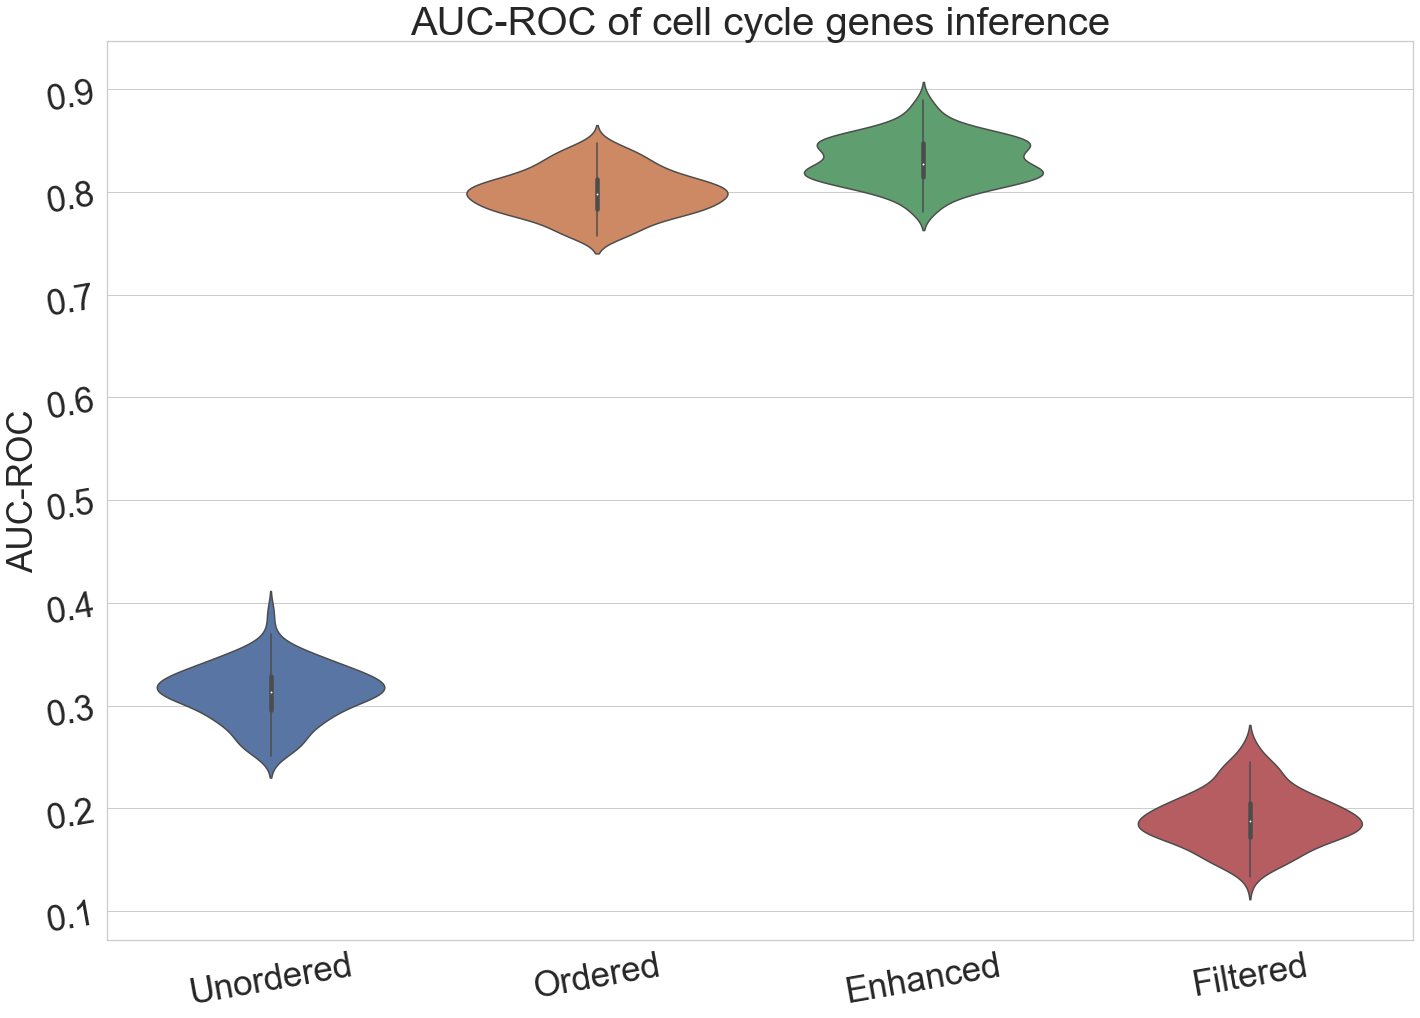

In [11]:
sns.set_style("whitegrid")

b = sns.violinplot(data=data)
#b.axes.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(rc={'figure.figsize':(23.4,16.54)})
b.axes.set_title("AUC-ROC of cell cycle genes inference",fontsize=40)
b.set_ylabel("AUC-ROC",fontsize=35)
b.tick_params(rotation=10,labelsize=35)
#b.axes.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


sns.set(rc={'figure.figsize':(23.4,16.54)})
#plt.title("MSE between simulated cyclic signal and output of enhancement methods" ,fontsize='24')

sns.set_style("whitegrid")

plt.show()